In [38]:
!python --version

Python 3.11.7


In [39]:
"""
%%capture

# The environment we will be working with
%pip install CityLearn==2.1.2

# For participant interactions (buttons)
%pip install ipywidgets

# To generate static figures
%pip install matplotlib
%pip install seaborn

# Provide standard RL algorithms
%pip install stable-baselines3

# Enable gym compatibility with later stable-baselines3 versions
%pip install shimmy

# Results submission
%pip install requests
%pip install beautifulsoup4
"""

'\n%%capture\n\n# The environment we will be working with\n%pip install CityLearn==2.1.2\n\n# For participant interactions (buttons)\n%pip install ipywidgets\n\n# To generate static figures\n%pip install matplotlib\n%pip install seaborn\n\n# Provide standard RL algorithms\n%pip install stable-baselines3\n\n# Enable gym compatibility with later stable-baselines3 versions\n%pip install shimmy\n\n# Results submission\n%pip install requests\n%pip install beautifulsoup4\n'

In [40]:
import sys, subprocess
print("Python:", sys.executable)
print("Pip:   ", subprocess.run(["which","pip"], capture_output=True, text=True).stdout)

# System operations
import os

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import import_ipynb

# Data manipulation
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch as th

# CityLearn
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction, SolarPenaltyReward

# Baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.monitor import Monitor


# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

Python: /hkfs/home/haicore/iai/cj9272/citylearn_env/bin/python
Pip:    /software/all/jupyter/ai/2025-05-23/bin/pip



In [41]:
def keep_only_electrical_storage(schema: dict) -> dict: # Set actions to just electical storage
    # Top-level actions
    if 'actions' in schema:
        for a in list(schema['actions'].keys()):
            schema['actions'][a]['active'] = (a == 'electrical_storage')

    # Per-building overrides, if present
    if 'buildings' in schema:
        for b in schema['buildings']:
            if 'actions' in b:
                for a in list(b['actions'].keys()):
                    b['actions'][a]['active'] = (a == 'electrical_storage')
    return schema


dataset = DataSet()
schema = dataset.get_schema('citylearn_challenge_2023_phase_3_1')
schema['root_directory'] = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
# Set reward function
schema['reward_function'] = { # CostReward Function
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
# Set pricing file
price_file = 'pricing_germany_2023_june_to_august.csv'  # Pricing CSV
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file


# Building
root_directory = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
building_name = 'Building_1'
# Weather data
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
# Pricing data (simple)
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
# Carbon Intensity data
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
# building data
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)

# Display building data
# display(building_data.head())
# display(building_data.describe(include='all'))

bld = building_data.copy()
wth = weather_data.copy()
prc = pricing_data.copy()
car = carbon_intensity_data.copy()

print(building_data.columns.tolist())

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 'indoor_dry_bulb_temperature_cooling_set_point', 'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode']


In [42]:
observations = [
    # building_df
    'month', 'hour', 'day_type', 'daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load', 'dhw_demand',
    'cooling_demand', 'heating_demand',
    'solar_generation', 'occupant_count',
    'indoor_dry_bulb_temperature_cooling_set_point',
    'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode',
    # weather_df
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance',
    'outdoor_dry_bulb_temperature_predicted_1',
    'outdoor_dry_bulb_temperature_predicted_2',
    'outdoor_dry_bulb_temperature_predicted_3',
    'outdoor_relative_humidity_predicted_1',
    'outdoor_relative_humidity_predicted_2',
    'outdoor_relative_humidity_predicted_3',
    'diffuse_solar_irradiance_predicted_1',
    'diffuse_solar_irradiance_predicted_2',
    'diffuse_solar_irradiance_predicted_3',
    'direct_solar_irradiance_predicted_1',
    'direct_solar_irradiance_predicted_2',
    'direct_solar_irradiance_predicted_3',
    # carbon_df 
    'carbon_intensity',
    # pricing_df
    'electricity_pricing',
    'electricity_pricing_predicted_1',
    'electricity_pricing_predicted_2',
    'electricity_pricing_predicted_3'
]
bld_cols = [
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity', 'non_shiftable_load',
            'dhw_demand', 'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point',
            'hvac_mode'
]
wth_cols = [
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance'
]

### Deep Q-Learning Agent
#### 1. Reward Function


In [43]:
class CustomReward(RewardFunction):
    def __init__(self, capacity: float):
        self.capacity = capacity
        self.prev_net_load = None

    def __call__(self, obs: Mapping[str, float], action_frac: float) -> float:
        # 1) Net load & cost
        net_load   = obs['non_shiftable_load'] - action_frac*self.capacity # max: 11.25 kW
        price = obs['electricity_pricing'] # 0.06605 or 0.03025
        cost  = max(0.0, net_load) * price # deviation range: 0-11.25*0.06605 = ~0-0.75$
        #norm_cost = cost / 0.75 # normalize to [0,1]

        # return -(w_cost*cost + w_pen*comfort_penalty + w_emis*emis + w_ramp*ramp)        
        return -cost

#### 2. Environment
I wrap the DataFrames in a Gym Environment
following the same pattern as the tutorial’s Tabular QL wrapper,
but here I implement a custom `gym.Env` that emits a vector of normalized
features and accepts a *discrete* charge/discharge action.


In [44]:
from citylearn.reward_function import ComfortReward, CostReward

class CityLearnDQNEnv(gym.Env):
    """
    Custom DQN environment over tabular CityLearn data.
    Adaptation A: filter out observation columns that are missing in the loaded CSVs
    to avoid KeyError (e.g. missing *_predicted_* columns).

    Updated: Supports both CityLearn reward classes (with `.calculate`) and a simple
    custom reward callable (with `__call__(obs, action_frac)`).
    """

    def __init__(self,
                 building_df: pd.DataFrame,
                 pricing_df:  pd.DataFrame,
                 weather_df:  pd.DataFrame,
                 carbon_df:   pd.DataFrame,
                 n_bins:      int = 5):
        super().__init__()
        # Raw data (reset index for integer-based access)
        self.bld = building_df.reset_index(drop=True)
        self.prc = pricing_df.reset_index(drop=True)
        self.wth = weather_df.reset_index(drop=True)
        self.car = carbon_df.reset_index(drop=True)
        self.T   = len(self.bld)  # episode length

        self.n_bins = int(n_bins)
        self.action_space = spaces.Discrete(self.n_bins)

        # ---- Dynamic observation column filtering (Adaptation A) ----
        raw_obs_cols = [
            # building_df
            'month','hour','day_type','daylight_savings_status',
            'indoor_dry_bulb_temperature','average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity','non_shiftable_load','dhw_demand',
            'cooling_demand','heating_demand','solar_generation','occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point','hvac_mode',
            # weather_df (actual)
            'outdoor_dry_bulb_temperature','outdoor_relative_humidity',
            'diffuse_solar_irradiance','direct_solar_irradiance',
            # weather_df (predicted – may be missing)
            'outdoor_dry_bulb_temperature_predicted_1',
            'outdoor_dry_bulb_temperature_predicted_2',
            'outdoor_dry_bulb_temperature_predicted_3',
            'outdoor_relative_humidity_predicted_1',
            'outdoor_relative_humidity_predicted_2',
            'outdoor_relative_humidity_predicted_3',
            'diffuse_solar_irradiance_predicted_1',
            'diffuse_solar_irradiance_predicted_2',
            'diffuse_solar_irradiance_predicted_3',
            'direct_solar_irradiance_predicted_1',
            'direct_solar_irradiance_predicted_2',
            'direct_solar_irradiance_predicted_3',
            # carbon & pricing
            'carbon_intensity',
            'electricity_pricing',
            'electricity_pricing_predicted_1',
            'electricity_pricing_predicted_2',
            'electricity_pricing_predicted_3'
        ]

        available_cols = (
            set(self.bld.columns)
            | set(self.wth.columns)
            | set(self.car.columns)
            | set(self.prc.columns)
        )
        self.obs_cols = [c for c in raw_obs_cols if c in available_cols]
        missing = [c for c in raw_obs_cols if c not in available_cols]
        if missing:
            print("Dropping missing observation columns:", missing)

        self.obs_amount = len(self.obs_cols)
        self.bound = 5.0
        low  = -np.ones(self.obs_amount, dtype=np.float32) * self.bound
        high =  np.ones(self.obs_amount, dtype=np.float32) * self.bound
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # --- Stats (only over columns that actually exist) ---
        parts = []
        parts.append(self.bld[[c for c in self.obs_cols if c in self.bld.columns]])
        parts.append(self.wth[[c for c in self.obs_cols if c in self.wth.columns]])
        if 'carbon_intensity' in self.obs_cols and 'carbon_intensity' in self.car.columns:
            parts.append(self.car[['carbon_intensity']])
        if 'electricity_pricing' in self.obs_cols and 'electricity_pricing' in self.prc.columns:
            parts.append(self.prc[['electricity_pricing']])

        all_obs_df = pd.concat(parts, axis=1)
        all_obs_df = all_obs_df.loc[:, ~all_obs_df.columns.duplicated()]
        all_obs_df = all_obs_df.reindex(columns=[c for c in self.obs_cols if c in all_obs_df.columns])
        self.obs_mean = all_obs_df.mean().reindex(self.obs_cols, fill_value=0).values.astype(np.float32)
        self.obs_std  = all_obs_df.std().replace(0, 1).reindex(self.obs_cols, fill_value=1).values.astype(np.float32)

        # Simple battery
        self.capacity = 1.0
        self.soc = 0.5

        self.reward_fn = CostReward(env_metadata=schema)
        # self.reward_fn = ComfortReward(env_metadata=schema, band=2.0, lower_exponent=2, higher_exponent=2)

        # Flag interface type
        self._uses_citylearn_interface = hasattr(self.reward_fn, 'calculate')

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.t = 0
        self.soc = 0.5
        obs = self._get_obs()
        return obs, {}

    def _build_row(self):
        """Assemble a dict of all currently available features for timestep t."""
        row_dict = {}
        for c in self.obs_cols:
            if c in self.bld.columns:
                row_dict[c] = self.bld.loc[self.t, c]
        for c in self.obs_cols:
            if c in self.wth.columns:
                row_dict[c] = self.wth.loc[self.t, c]
        if 'carbon_intensity' in self.obs_cols and 'carbon_intensity' in self.car.columns:
            row_dict['carbon_intensity'] = self.car.loc[self.t, 'carbon_intensity']
        if 'electricity_pricing' in self.obs_cols and 'electricity_pricing' in self.prc.columns:
            row_dict['electricity_pricing'] = self.prc.loc[self.t, 'electricity_pricing']
        return row_dict

    def _get_obs(self):
        row_dict = self._build_row()
        x = np.array([row_dict.get(c, 0.0) for c in self.obs_cols], dtype=np.float32)
        # Optional normalization disabled:
        # z = (x - self.obs_mean)/self.obs_std
        # np.clip(z, -self.bound, self.bound, out=z)
        return x

    def step(self, action):
        # Map discrete action to [-1,1]
        frac = -1.0 + 2.0 * (action / (self.n_bins - 1))
        # Update SoC (very simple dynamic)
        self.soc = float(np.clip(self.soc + 0.1 * frac, 0.0, self.capacity))

        # Build minimal reward observation dict
        reward_obs = {
            'non_shiftable_load': float(self.bld.loc[self.t, 'non_shiftable_load']) if 'non_shiftable_load' in self.bld.columns else 0.0,
            'electricity_pricing': float(self.prc.loc[self.t, 'electricity_pricing']) if 'electricity_pricing' in self.prc.columns else 0.0,
            'hvac_mode': float(self.bld.loc[self.t, 'hvac_mode']) if 'hvac_mode' in self.bld.columns else 0.0,
            'indoor_dry_bulb_temperature': float(self.bld.loc[self.t, 'indoor_dry_bulb_temperature']) if 'indoor_dry_bulb_temperature' in self.bld.columns else 0.0,
            'indoor_dry_bulb_temperature_cooling_set_point': float(self.bld.loc[self.t, 'indoor_dry_bulb_temperature_cooling_set_point']) if 'indoor_dry_bulb_temperature_cooling_set_point' in self.bld.columns else 0.0,
            'indoor_dry_bulb_temperature_heating_set_point': float(self.bld.loc[self.t, 'indoor_dry_bulb_temperature_heating_set_point']) if 'indoor_dry_bulb_temperature_heating_set_point' in self.bld.columns else 0.0,
        }
        # Optional: include solar and battery effect if you want a net value (ComfortReward may not need it, other rewards might):
        solar = float(self.bld.loc[self.t, 'solar_generation']) if 'solar_generation' in self.bld.columns else 0.0
        reward_obs['net_electricity_consumption'] = reward_obs['non_shiftable_load'] - solar - (frac * self.capacity)

        if self._uses_citylearn_interface:
            # CityLearn reward classes expect list[dict]
            reward_list = self.reward_fn.calculate(observations=[reward_obs])
            reward = float(reward_list[0])
        else:
            # Custom callable reward: (obs_dict, action_fraction)
            reward = float(self.reward_fn(reward_obs, frac))

        # Advance time
        self.t += 1
        terminated = (self.t >= self.T)
        truncated = False
        obs = self._get_obs() if not terminated else np.zeros(len(self.obs_cols), dtype=np.float32)
        return obs, reward, terminated, truncated, {}

    def render(self, mode='human'):
        pass

In [45]:
from citylearn.reward_function import ComfortReward, CostReward, SolarPenaltyReward

# Instantiate the reward function you care about (adjust params as needed)
reward_fn = ComfortReward(env_metadata=schema, band=2.0, lower_exponent=2, higher_exponent=2)
# reward_fn = CostReward()
# reward_fn = SolarPenaltyReward(env_metadata=schema)

class AccessLoggingObs(dict):
    """
    Dict that logs every key access and returns a default numeric value for missing keys
    so the reward function can proceed without KeyErrors.
    """
    def __init__(self, default_value=0.0):
        super().__init__()
        self.accessed_keys = set()
        self.default_value = default_value
    def __getitem__(self, key):
        self.accessed_keys.add(key)
        return super().get(key, self.default_value)

# Build one (or more) dummy observations
dummy_obs = AccessLoggingObs(default_value=0.0)

# Call the standard CityLearn interface (list of obs dicts)
_ = reward_fn.calculate(observations=[dummy_obs])

required_keys = sorted(dummy_obs.accessed_keys)
print("Keys accessed by", type(reward_fn).__name__, ":\n", required_keys)

Keys accessed by ComfortReward :
 ['hvac_mode', 'indoor_dry_bulb_temperature', 'indoor_dry_bulb_temperature_cooling_set_point', 'indoor_dry_bulb_temperature_heating_set_point']


In [46]:
class TrainLoggerCallback(BaseCallback):
    """Logging State, Action, Reward per step and Loss per update phase."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Will collect a dict per env-step
        self.rows = []
        # Loss values and their timesteps (global)
        self.losses = []
        self.loss_timesteps = []
        # Completed episode returns (global list)
        self.episode_rewards = []
        # Placeholders for per-env tracking
        self._current_ep_rewards = []         # sum of rewards in current episode per env
        self._current_ep_counts = []          # episode index per env
        self._current_step_in_episode = []    # step counter (0..T-1) per env

        # DataFrames to populate at end
        self.df = pd.DataFrame()
        self.ep_df = pd.DataFrame()

    def _on_training_start(self) -> None:
        try:
            n_envs = self.training_env.num_envs
        except AttributeError:
            n_envs = 1
        # initialize counters per sub-env
        self._current_ep_rewards = [0.0] * n_envs
        self._current_ep_counts = [1] * n_envs
        self._current_step_in_episode = [0] * n_envs
        super()._on_training_start()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        step    = int(self.num_timesteps)

        # log loss if present
        loss_val = self.logger.name_to_value.get("train/loss")
        if loss_val is not None:
            self.losses.append(float(loss_val))
            self.loss_timesteps.append(step)

        # iterate each sub-env
        for idx, (obs, act, rew, done) in enumerate(zip(obs_vec, acts, rews, dones)):
            # flatten observation
            flat = obs.flatten().tolist()
            # build row with metadata
            row = {f"x{i}": flat[i] for i in range(len(flat))}
            row.update({
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "step_in_ep": self._current_step_in_episode[idx],
                "action": int(act),
                "reward": float(rew),
                "global_step": step
            })
            self.rows.append(row)

            # accumulate per-episode reward
            self._current_ep_rewards[idx] += float(rew)
            # increment step in episode
            self._current_step_in_episode[idx] += 1

            # if end of episode for this env
            if done:
                # log reward and finalize episode
                print(f"Env {idx} Episode {self._current_ep_counts[idx]} done at global step {step}, total reward: {self._current_ep_rewards[idx]:.3f}")
                self.episode_rewards.append(self._current_ep_rewards[idx])
                # reset for next episode
                self._current_ep_rewards[idx] = 0.0
                self._current_ep_counts[idx] += 1
                self._current_step_in_episode[idx] = 0

        return True

    def _on_training_end(self) -> None:
        # build full-step DataFrame
        self.df = pd.DataFrame(self.rows)
        # build episodes summary DataFrame
        self.ep_df = pd.DataFrame({
            "episode_global": range(1, len(self.episode_rewards) + 1),
            "return": self.episode_rewards
        })
        super()._on_training_end()

In [47]:
def make_env(idx):
    def _init():
        env = CityLearnDQNEnv(
            building_df=bld,
            pricing_df=prc,
            weather_df=wth,
            carbon_df=car,
            n_bins=5
        )
        return Monitor(env)  # record episode stats
    return _init

# Launch parallel environments
n_envs = 3
train_env = SubprocVecEnv([make_env(i) for i in range(n_envs)])
train_env = VecMonitor(train_env)
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# Single-process eval env wrapped in Monitor
eval_env = DummyVecEnv([lambda: Monitor(CityLearnDQNEnv(building_df=bld, pricing_df=prc, weather_df=wth, carbon_df=car, n_bins=5))])
eval_env = VecMonitor(eval_env) 
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Evaluate every 2k steps over 5 episodes
eval_callback = EvalCallback(
    eval_env,
    log_path="logs/eval/",
    best_model_save_path="logs/best_model/",
    #eval_freq=len(building_data), # run evaluation every 5k timesteps, TODO: change to 5_000
    eval_freq=1000, # run evaluation every n timesteps, TODO: change n to 5_000
    n_eval_episodes=5,       # average over 5 full episodes
    deterministic=True,
    verbose=1
)

train_callback = TrainLoggerCallback()

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=3e-4, # slower to stabilize training
    buffer_size=100_000, 
    batch_size=128, 
    learning_starts=2_000, # start learning after 2000 steps, so enough experience is collected in replay-buffer
    train_freq= 256, # update the model every 256 steps
    target_update_interval= 500, # update the target network every 500 steps to avoid bull-whip effects (increasing oscillations)
    exploration_fraction= 0.3, # longer exploration until epsilon sinks to min value
    exploration_initial_eps= 1.0, # start with 100% exploration
    exploration_final_eps= 0.02, # near deterministic policy at the end
    gamma=0.98, # how much future rewards are discounted, 0.98 = 2% discount
    verbose=1, # 1 = info, 2 = debug
    policy_kwargs=dict(
        net_arch=[256, 256, 256],
        activation_fn=th.nn.ReLU,
        #dueling=True,
    ),
) 

# Model training
T = len(building_data) # 1 episode = 2208 timesteps
num_episodes = 10 # 10 episodes
model.learn(
    total_timesteps=n_envs * num_episodes * T,
    callback=CallbackList([train_callback, eval_callback])
)

print("Eval timesteps:", eval_callback.evaluations_timesteps)
print("Eval results   :", eval_callback.evaluations_results)


print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)


# Evaluation results
all_rewards = eval_callback.evaluations_results # List of lists: each element are rewards from an eval round
eval_steps  = eval_callback.evaluations_timesteps # timesteps at which the evaluations were run

# Mean reward per round
mean_rewards = [np.mean(r) for r in all_rewards]

2025-08-18 17:24:24.244751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 17:24:24.257641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755530664.270016  702801 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755530664.273709  702801 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755530664.284722  702801 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Eval num_timesteps=3000, episode_reward=-29.93 +/- 0.05
Episode length: 2208.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.21e+03 |
|    mean_reward      | -29.9    |
| rollout/            |          |
|    exploration_rate | 0.852    |
| time/               |          |
|    total_timesteps  | 3000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00698  |
|    n_updates        | 1        |
----------------------------------
New best mean reward!
Eval num_timesteps=6000, episode_reward=-2.06 +/- 0.01
Episode length: 2208.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.21e+03 |
|    mean_reward      | -2.06    |
| rollout/            |          |
|    exploration_rate | 0.704    |
| time/               |          |
|    total_timesteps  | 6000     |
| train/              |          |
|    learning

=== DQN Run Logging ===
Episode stats: {'episodes': 30, 'return_mean': -37.909008272588835, 'return_std': 32.19160531666509, 'return_min': -108.25261853914708, 'return_max': -8.242487205949146, 'return_med': -22.896718836389482}
Action distribution: {0: 10473, 1: 10151, 2: 10386, 3: 11873, 4: 23933}
Saved files:
  steps_csv: logs/run_summary/train_steps.csv
  episodes_csv: logs/run_summary/episode_returns.csv
  eval_csv: logs/run_summary/eval_summary.csv
  summary_json: logs/run_summary/run_summary.json


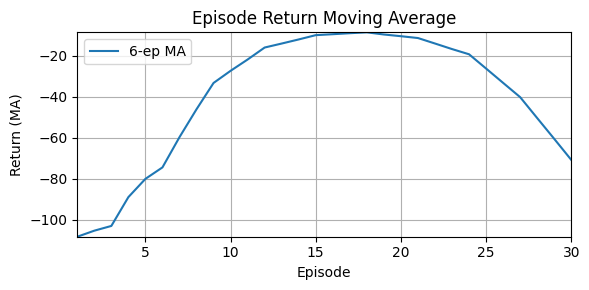

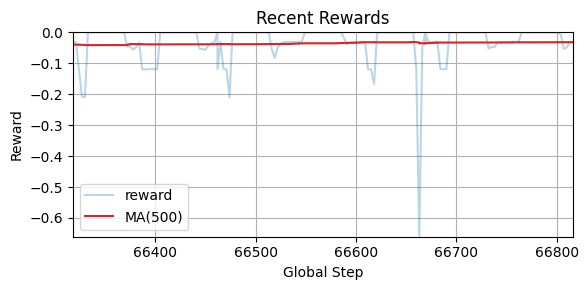

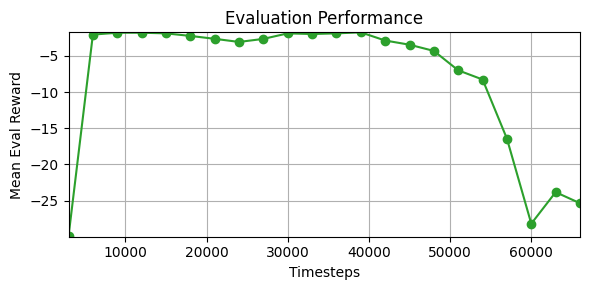

{'timestamp_utc': '2025-08-18T15:36:21.302015Z',
 'episode_stats': {'episodes': 30,
  'return_mean': -37.909008272588835,
  'return_std': 32.19160531666509,
  'return_min': -108.25261853914708,
  'return_max': -8.242487205949146,
  'return_med': -22.896718836389482},
 'action_distribution': {0: 10473, 1: 10151, 2: 10386, 3: 11873, 4: 23933},
 'action_frequency': {0: 0.1567438936781609,
  1: 0.151924688697318,
  2: 0.1554418103448276,
  3: 0.17769695881226052,
  4: 0.35819264846743293},
 'action_mapping_fraction': {0: np.float64(-1.0),
  1: np.float64(-0.5),
  2: np.float64(0.0),
  3: np.float64(0.5),
  4: np.float64(1.0)},
 'n_steps_logged': 66816,
 'n_eval_points': 22,
 'hyperparameters': {'algo': 'DQN',
  'learning_rate': 0.0003,
  'gamma': 0.98,
  'buffer_size': 100000,
  'batch_size': 128,
  'train_freq': 'step',
  'target_update_interval': 500,
  'exploration_fraction': 0.3,
  'exploration_initial_eps': 1.0,
  'exploration_final_eps': 0.02,
  'net_arch': [256, 256, 256],
  'activa

In [49]:
# Post-training logging & summary
import os, json, numpy as np, pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

print("=== DQN Run Logging ===")

# Basic safety checks
needed = ['train_callback', 'model']
for v in needed:
    if v not in globals():
        raise RuntimeError(f"{v} not found. Run training first.")

if not hasattr(train_callback, 'df') or train_callback.df is None or train_callback.df.empty:
    raise RuntimeError("train_callback has no logged steps. Ensure training completed.")

step_df = train_callback.df.sort_values('global_step').reset_index(drop=True)
ep_df   = train_callback.ep_df.copy() if hasattr(train_callback, 'ep_df') else pd.DataFrame()

# Episode stats
if not ep_df.empty:
    r = ep_df['return']
    ep_stats = {
        'episodes'     : int(len(r)),
        'return_mean'  : float(r.mean()),
        'return_std'   : float(r.std(ddof=0)),
        'return_min'   : float(r.min()),
        'return_max'   : float(r.max()),
        'return_med'   : float(r.median()),
    }
else:
    ep_stats = {}

# Action distribution
if 'action' not in step_df.columns:
    raise RuntimeError("No 'action' column in step_df.")
action_counts = step_df['action'].value_counts().sort_index()
action_dist = {int(k): int(v) for k, v in action_counts.items()}
total_actions = int(action_counts.sum())
action_freq = {k: v/total_actions for k, v in action_dist.items()}

# Discrete → fraction mapping (mirrors env mapping)
n_actions = model.action_space.n
action_mapping = {a: -1.0 + 2.0*(a/(n_actions-1)) for a in range(n_actions)}

# Moving averages
def moving_average(series, window):
    return series.rolling(window, min_periods=1).mean()

if 'reward' in step_df.columns:
    step_df['reward_ma_500'] = moving_average(step_df['reward'], 500)
else:
    step_df['reward_ma_500'] = np.nan

# Eval summary if available
eval_summary = []
if 'eval_callback' in globals() and hasattr(eval_callback, 'evaluations_results'):
    for ts, rewards in zip(eval_callback.evaluations_timesteps, eval_callback.evaluations_results):
        arr = np.array(rewards, dtype=float)
        eval_summary.append({
            'timesteps'      : int(ts),
            'mean_reward'    : float(arr.mean()),
            'std_reward'     : float(arr.std(ddof=0)),
            'min_reward'     : float(arr.min()),
            'max_reward'     : float(arr.max()),
            'n_eval_episodes': int(len(arr))
        })
eval_df = pd.DataFrame(eval_summary)

# Hyperparameters (subset)
hp = {
    'algo'                  : 'DQN',
    'learning_rate'         : float(model.learning_rate),
    'gamma'                 : float(model.gamma),
    'buffer_size'           : int(model.buffer_size),
    'batch_size'            : int(model.batch_size),
    'train_freq'            : model.train_freq.unit.value,
    'target_update_interval': int(model.target_update_interval),
    'exploration_fraction'  : float(model.exploration_fraction),
    'exploration_initial_eps': float(model.exploration_initial_eps),
    'exploration_final_eps' : float(model.exploration_final_eps),
    'net_arch'              : getattr(model.policy, 'net_arch', None),
    'activation_fn'         : type(model.policy.activation_fn).__name__,
}

summary = {
    'timestamp_utc'        : datetime.utcnow().isoformat() + 'Z',
    'episode_stats'        : ep_stats,
    'action_distribution'  : action_dist,
    'action_frequency'     : action_freq,
    'action_mapping_fraction': action_mapping,
    'n_steps_logged'       : int(len(step_df)),
    'n_eval_points'        : int(len(eval_df)),
    'hyperparameters'      : hp,
}

# Persist
out_dir = 'logs/run_summary'
os.makedirs(out_dir, exist_ok=True)
paths = {
    'steps_csv' : os.path.join(out_dir, 'train_steps.csv'),
    'episodes_csv': os.path.join(out_dir, 'episode_returns.csv'),
    'eval_csv'  : os.path.join(out_dir, 'eval_summary.csv'),
    'summary_json': os.path.join(out_dir, 'run_summary.json')
}
step_df.to_csv(paths['steps_csv'], index=False)
ep_df.to_csv(paths['episodes_csv'], index=False)
eval_df.to_csv(paths['eval_csv'], index=False)
with open(paths['summary_json'], 'w') as f:
    json.dump(summary, f, indent=2)

print("Episode stats:", ep_stats)
print("Action distribution:", action_dist)
print("Saved files:")
for k, v in paths.items():
    print(f"  {k}: {v}")

# Quick plots
if not ep_df.empty:
    plt.figure(figsize=(6,3))
    window = max(1, min(50, len(ep_df)//5))
    ep_df['return_ma'] = ep_df['return'].rolling(window, min_periods=1).mean()
    plt.plot(ep_df['episode_global'], ep_df['return_ma'], label=f'{window}-ep MA', color='C0')
    plt.xlabel('Episode'); plt.ylabel('Return (MA)')
    plt.title('Episode Return Moving Average')
    plt.grid(True); plt.tight_layout(); plt.legend(); plt.show()

if 'reward' in step_df.columns and len(step_df) > 0:
    tail = step_df.tail(min(500, len(step_df)))
    plt.figure(figsize=(6,3))
    plt.plot(tail['global_step'], tail['reward'], alpha=0.3, label='reward')
    plt.plot(tail['global_step'], tail['reward_ma_500'], color='C3', label='MA(500)')
    plt.xlabel('Global Step'); plt.ylabel('Reward')
    plt.title('Recent Rewards')
    plt.grid(True); plt.tight_layout(); plt.legend(); plt.show()

if not eval_df.empty:
    plt.figure(figsize=(6,3))
    plt.errorbar(eval_df['timesteps'], eval_df['mean_reward'],
                 yerr=eval_df['std_reward'], fmt='-o', capsize=3, color='C2')
    plt.xlabel('Timesteps'); plt.ylabel('Mean Eval Reward')
    plt.title('Evaluation Performance')
    plt.grid(True); plt.tight_layout(); plt.show()

summary

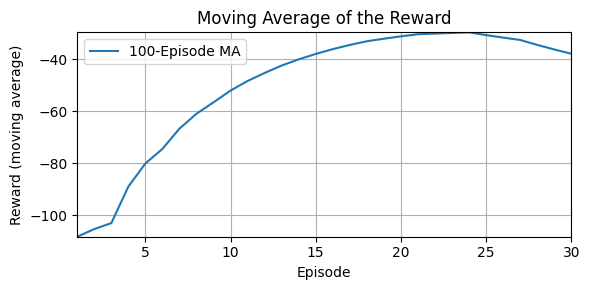

Total episodes: 30


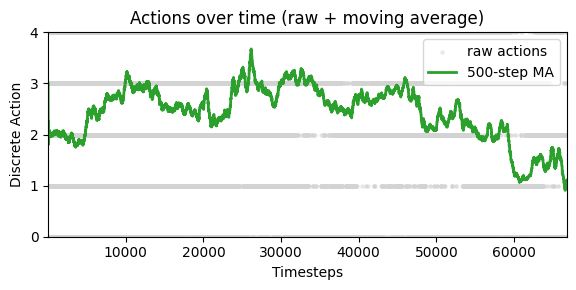

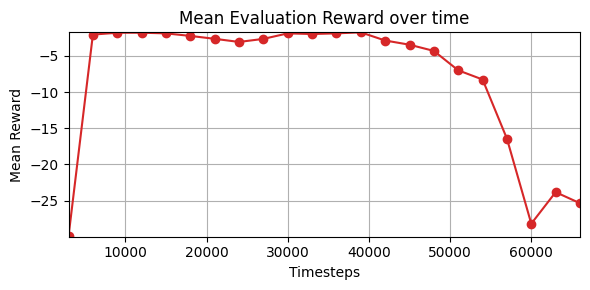

In [50]:
# Training reward over Episodes
window = 100
smooth = train_callback.ep_df["return"].rolling(window, min_periods=1).mean()
#train_df = train_callback.df  # your TrainLoggerCallback should have produced this
plt.figure(figsize=(6, 3))
plt.plot(train_callback.ep_df["episode_global"], smooth, label=f"{window}-Episode MA", color="C0")
#plt.plot(train_df["step"], train_df["reward"], color="C0")
plt.title("Moving Average of the Reward")
plt.xlabel("Episode")
plt.ylabel("Reward (moving average)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
n_episodes = len(train_callback.ep_df)
print(f"Total episodes: {n_episodes}")
"""
# Training loss (if available)
if hasattr(train_callback, "losses") and len(train_callback.losses) > 0:
    plt.figure(figsize=(6, 3))
    plt.plot(train_callback.loss_timesteps,
             train_callback.losses,
             marker='.', linestyle='-',
             alpha=0.7, color="C1")
    plt.title("Train Loss over time")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""

train_df = train_callback.df  
# Actions over Time
plt.figure(figsize=(6, 3))
# Raw actions
plt.scatter(
    train_df["global_step"],
    train_df["action"],
    c="lightgray", s=5, alpha=0.4,
    label="raw actions"
)
# Moving average
window = 500
train_df["action_ma"] = train_df["action"].rolling(window, min_periods=1).mean()
plt.plot(
    train_df["global_step"],
    train_df["action_ma"],
    color="C2", lw=2,
    label=f"{window}-step MA"
)
plt.title("Actions over time (raw + moving average)")
plt.xlabel("Timesteps")
plt.ylabel("Discrete Action")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Evaluation results
all_eval = eval_callback.evaluations_results        # list of lists
steps    = eval_callback.evaluations_timesteps      # list of ints

# Compute per‐evaluation mean/std
mean_eval = [float(np.mean(r)) for r in all_eval]
std_eval  = [float(np.std(r))  for r in all_eval]

plt.figure(figsize=(6, 3))
plt.errorbar(
    steps, mean_eval,
    yerr=std_eval,
    fmt='-o', capsize=3, color="C3",
    label="Eval mean ±1σ"
)
plt.title("Mean Evaluation Reward over time")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.tight_layout()
plt.show()